In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
import torch

from DiffWarping import Almtx
import main_utils


# Plot signals

In [13]:

def plot_mean_signal(X_aligned_within_class, X_within_class, ratio, class_num, align_num, dataset_name, N=10):

    #check data dim
    if len(X_aligned_within_class.shape) < 3:
        X_aligned_within_class = np.expand_dims(X_aligned_within_class, axis=-1)

    # data dims: (number of samples, dim, channels)
    n_signals = len(X_within_class)  # number of samples within class

    # Sample random signals
    input_shape = X_within_class.shape[1:]  # (channels, dims) PyTorch
    signal_len = input_shape[1]
    n_channels = input_shape[0]

    indices = np.random.choice(n_signals, N)  # N samples
    X_within_class = X_within_class[indices, :, :]  # get N samples, all channels
    X_aligned_within_class = X_aligned_within_class[indices, :, :]

    # Compute mean signal and variance
    X_mean_t = np.mean(X_aligned_within_class, axis=0)
    X_std_t = np.std(X_aligned_within_class, axis=0)
    upper_t = X_mean_t + X_std_t
    lower_t = X_mean_t - X_std_t

    X_mean = np.mean(X_within_class, axis=0)
    X_std = np.std(X_within_class, axis=0)
    upper = X_mean + X_std
    lower = X_mean - X_std

    # set figure size
    [w, h] = ratio  # width, height
    f = plt.figure(1)
    plt.style.use('seaborn-darkgrid')
    # plt.rc('font', size=10)
    f.set_size_inches(w, n_channels * h)

    title_font = 15
    rows = 2
    cols = 2
    plot_idx = 1
    # plot each channel
    for channel in range(n_channels):
        t_1 = range(input_shape[1])
        # Misaligned Signals
        ax1 = f.add_subplot(rows, cols, plot_idx)
        ax1.plot(X_within_class[:, channel,:].T)
        plt.tight_layout()
        plt.xlim(0, signal_len)

        if n_channels == 1:
            #plt.title("%d random test samples" % (N))
            plt.title("Misaligned signals", fontsize=title_font)
        else:
            plt.title("Channel: %d, %d random test samples" % (channel, N))
        plot_idx += 1

        # Misaligned Mean
        ax2 = f.add_subplot(rows, cols, plot_idx)
        ax2.plot(t_1, X_mean[channel], 'r',label='Average signal')
        ax2.fill_between(t_1, upper[channel], lower[channel], color='r', alpha=0.2, label=r"$\pm\sigma$")
        #plt.legend(loc='upper right', fontsize=12, frameon=True)
        plt.xlim(0, signal_len)

        if n_channels ==1:
            plt.title("Misaligned average signal", fontsize=title_font)
        else:
            plt.title(f"Channel: {channel}, Test data mean signal ({N} samples)")

        plot_idx += 1


        # Aligned signals
        ax3 = f.add_subplot(rows, cols, plot_idx)
        ax3.plot(X_aligned_within_class[:, channel,:].T)
        plt.title("Aligned signals", fontsize=title_font)
        plt.xlim(0, align_num)
        

        plot_idx += 1

        # Aligned Mean
        t_2 = range(align_num)
        ax4 = f.add_subplot(rows, cols, plot_idx)
        ax4.plot(t_2, X_mean_t[channel,:], label='Average signal')
        ax4.fill_between(t_2, upper_t[channel], lower_t[channel], color='#539caf', alpha=0.6, label=r"$\pm\sigma$")
        plt.xlim(0, align_num)
        #plt.legend(loc='upper right', fontsize=12, frameon=True)
        plt.title("Aligned average signal", fontsize=title_font)
        
        plt.tight_layout()

        plot_idx += 1

    plt.suptitle(f"{dataset_name}: class-{class_num}", fontsize=title_font+2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()
    plt.savefig(f'./img/{dataset_name}_{int(class_num)}.svg', format='svg')
    plt.show()

def plot_signals(get_almtx, device, data_path, N=10):
    # Close any remaining plots
    plt.close('all')

    with torch.no_grad():
        # Torch channels first
        train = pd.read_csv(data_path + 'train.csv')

        train.rename(columns={'187':"Class"}, inplace=True)
        data, labels = np.array(train.iloc[:,1:188]), np.array(train.iloc[:,-1])

        # torch dim
        X = torch.Tensor(data).unsqueeze(1).float().to(device)
        y = labels
        classes = np.unique(y)
        # transformed_input_tensor, thetas = get_almtx(X, return_theta=True)

        b = 256
        sns.set_style("whitegrid")
        #fig, axes = plt.subplots(1,2)
        for label in classes:
            class_idx = y == label
            
            X_within_class = X[class_idx]
            X_within_class = X_within_class[:b]

            non_pad_mask = torch.zeros(X_within_class.shape).to(device)
            non_pad_mask[X_within_class > 0] = 1
            transformed_input_tensor, _ = get_almtx(X_within_class, mask=non_pad_mask) # [b l s]
            transformed_data_numpy = transformed_input_tensor.data.cpu().numpy()
            align_num = transformed_data_numpy.shape[-1]

            X_within_class = X_within_class.data.cpu().numpy()

            #print(X_aligned_within_class.shape, X_within_class.shape)
            plot_mean_signal(transformed_data_numpy, X_within_class, ratio=[8,6],
                                class_num=label, align_num=align_num,  dataset_name=f"ECG", N=N)

In [8]:
classifier = None
seq_len, n_vars = 187, 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

align = 100
warp='cpab'

ckpt_path = './ckpt/resnet_{}{}_seed0.h5'.format(warp, align)
get_almtx_net = Almtx(seq_len, n_vars, align, device,  warp=warp)
classifier, get_almtx_net = main_utils.load_checkpoints(ckpt_path, classifier, get_almtx_net)

/tmp/ipykernel_247680/4093487240.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


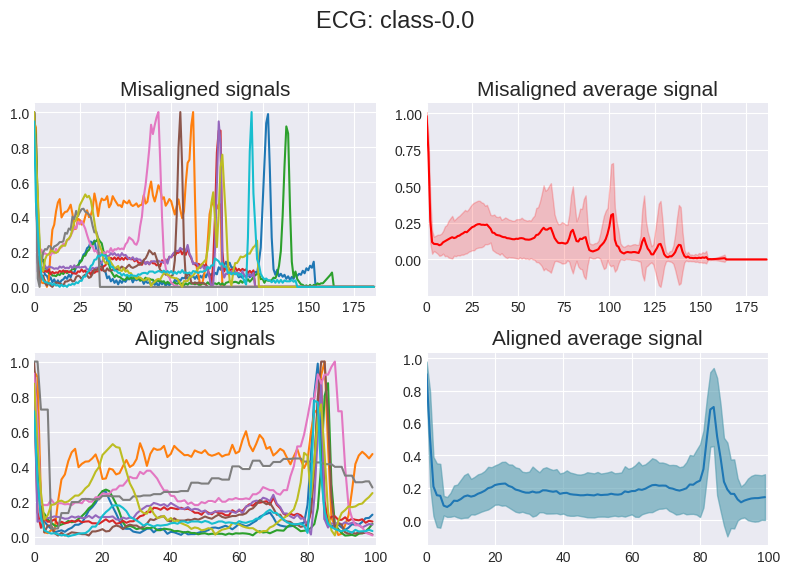

/tmp/ipykernel_247680/4093487240.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


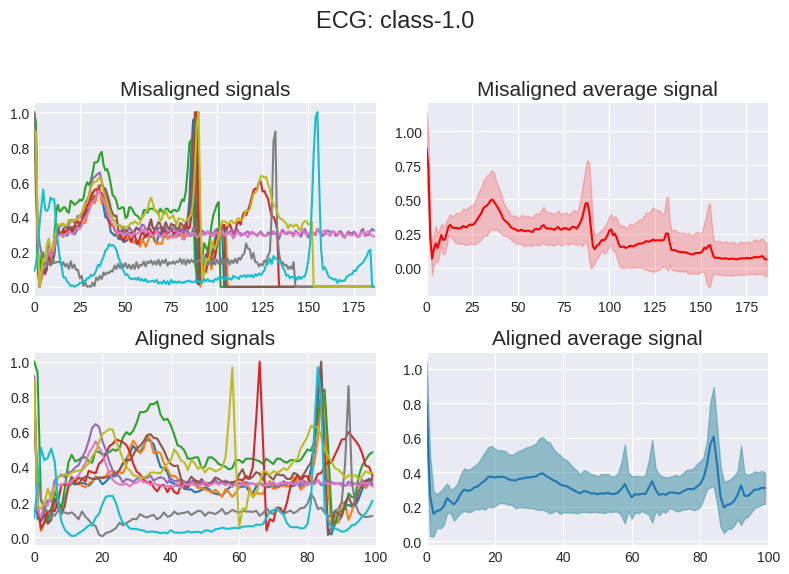

/tmp/ipykernel_247680/4093487240.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


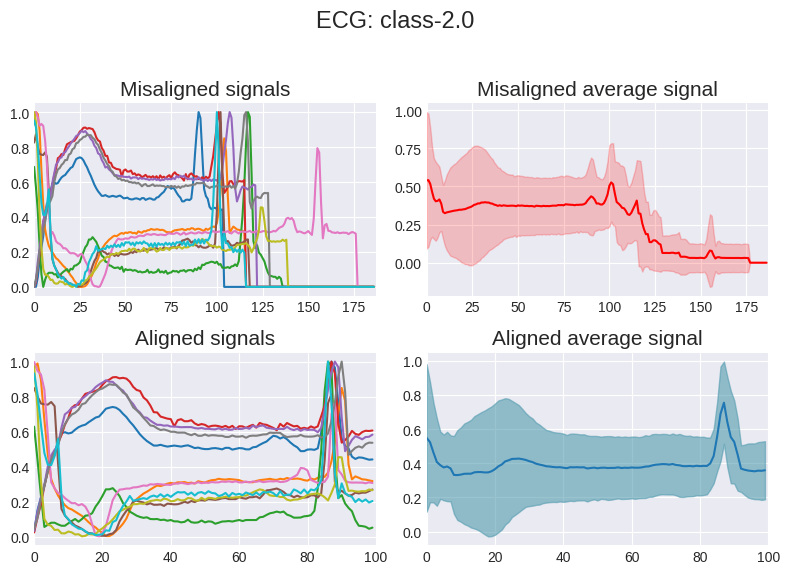

/tmp/ipykernel_247680/4093487240.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


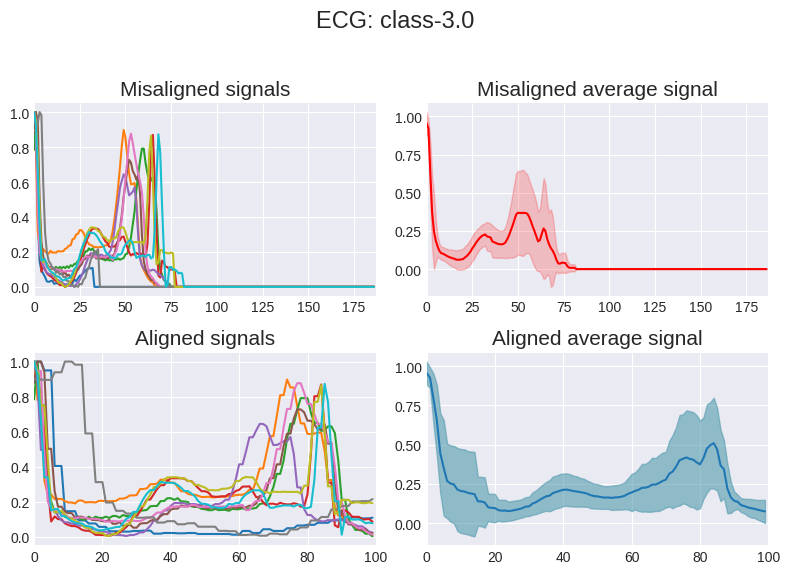

/tmp/ipykernel_247680/4093487240.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


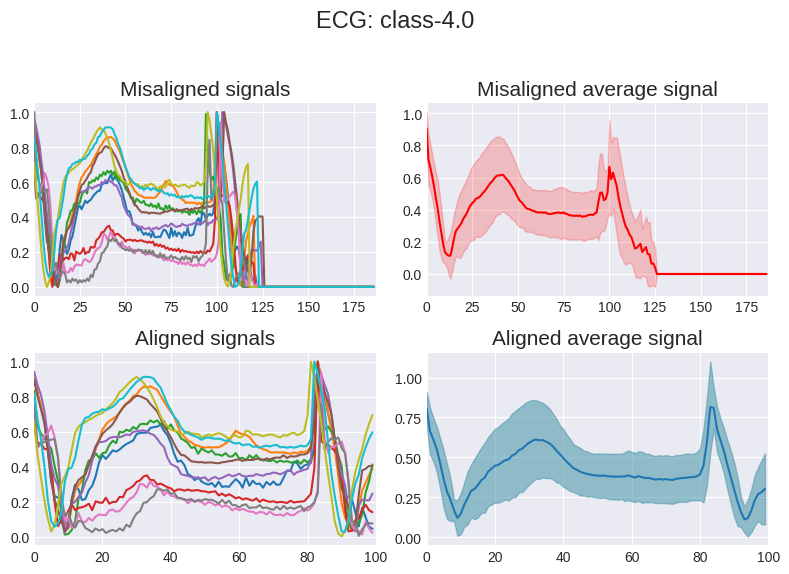

In [15]:
data_path = './data/'
plot_signals(get_almtx_net, device, data_path, N=10)